# **Darknet detection**


---

  
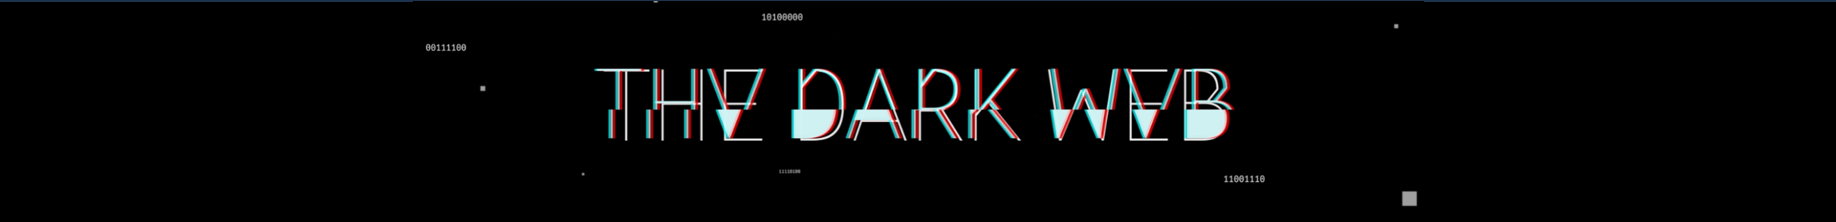







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
# @title Importing dataset

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Darknet raw.csv")
dataset.shape

(141530, 85)

In [ ]:
# @title Features names


In [ ]:
# Get the row using iloc and then retrieve the column names
column_names = dataset.columns
targets = ['Label', 'Label.1']
feature_names = [col for col in column_names if col not in targets]

print("Feature names:")
print(feature_names)
counts = len(feature_names)
print(f"\nThey are: {counts} features")

Feature names:
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'A

In [ ]:
# @title Print all unique labels


In [ ]:
Senario1_labels = dataset.iloc[:,-2].unique()
Senario2_labels = dataset.iloc[:,-1].unique()

print(f"Senario1 labels:\n{Senario1_labels}\n")
print(f"Senario2 labels:\n{Senario2_labels}")

Senario1 labels:
['Non-Tor' 'NonVPN' 'Tor' 'VPN']

Senario2 labels:
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [ ]:
Senario1_label_counts = dataset.iloc[:, -2].value_counts()
Senario2_label_counts = dataset.iloc[:, -1].value_counts()

print(f"Seanrio1 label counts:\n{Senario1_label_counts}\n")
print(f"Seanrio2 label counts:\n{Senario2_label_counts}")

Seanrio1 label counts:
Non-Tor    93356
NonVPN     23863
VPN        22919
Tor         1392
Name: Label, dtype: int64

Seanrio2 label counts:
P2P                48520
Browsing           32808
Audio-Streaming    16580
Chat               11478
File-Transfer      11098
Video-Streaming     9486
Email               6145
VOIP                3566
AUDIO-STREAMING     1484
Video-streaming      281
File-transfer         84
Name: Label.1, dtype: int64


In [ ]:
# @title Droping Flow ID column


In [ ]:
def drop_column(data, feature_names):
  columns = ['Flow ID']
  # Drop the specified columns
  data = dataset.drop(columns=columns, axis=1)
  feature_names = [col for col in feature_names if col not in columns]
  return data, feature_names

In [ ]:
dropped_data, dropped_feature_names = drop_column(dataset, feature_names)

In [ ]:
# @title Defining preprocessing functions


In [ ]:
# @title Handling missing values in the dataset


In [ ]:
missing_flag = False

for column in dropped_data.columns:
    missing_count = dropped_data[column].isnull().sum()
    if missing_count > 0:
        print(f"Feature '{column}' has {missing_count} missing values.")
        missing_flag = True

if not missing_flag:
    print("No missing data in the whole dataset.")

Feature 'Flow Bytes/s' has 47 missing values.


In [ ]:
def missing_delete(data):
    data = data.dropna()
    return data

In [ ]:
clean_data = missing_delete(dropped_data)

In [ ]:
# @title Handling categorical features


In [ ]:
categorical_columns = clean_data.select_dtypes(exclude=['float64', 'int64']).columns

if len(categorical_columns) > 0:
    print("The dataset has categorical columns.")
    print("Categorical columns:", list(categorical_columns))
else:
    print("The dataset does not have any categorical columns.")

The dataset has categorical columns.
Categorical columns: ['Src IP', 'Dst IP', 'Timestamp', 'Label', 'Label.1']


In [ ]:
def cat_conv(data):
    data.loc[:,'Src IP'] = data.loc[:,'Src IP'].apply(hash).astype('int64')
    data.loc[:,'Dst IP'] = data.loc[:,'Dst IP'].apply(hash).astype('int64')
    data.loc[:,'Timestamp'] = data.loc[:,'Timestamp'].apply(hash).astype('int64')

    return data

In [ ]:
clean_data = cat_conv(clean_data)

In [ ]:
# @title Creating X and y


In [ ]:
def X_y_creation(dataset, label_index):
    from sklearn.model_selection import train_test_split
    X = dataset.iloc[:, :-2]
    y = dataset.iloc[:, label_index]
    return X, y

In [ ]:
# X, y for Scenario1
X, y_binary = X_y_creation(clean_data, -2)

In [ ]:
# X, y for Multi-class for Scenario2
X, y_multi = X_y_creation(clean_data, -1)

In [ ]:
# @title Dropping infinite values


In [ ]:
def infinite_value_drop(X, y):
    # Replacing infinite features with NaN
    X_inf_dropped = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    # Droping NaN features
    y_inf_dropped = y[X.index.isin(X_inf_dropped.index)]
    return X_inf_dropped, y_inf_dropped

In [ ]:
# Dropping infinite values for Scenario1
X_inf_dropped, y_binary_inf_dropped = infinite_value_drop(X, y_binary)

In [ ]:
# Dropping infinite values for Scenario2
X_inf_dropped, y_multi_inf_dropped = infinite_value_drop(X, y_multi)

In [ ]:
# @title Converting labels for Scenario1

In [ ]:
# Create a new column 'y' based on the mapping
def converting_binary(y):
    y = y.map({'VPN': 'Darknet', 'Tor': 'Darknet', 'NonVPN': 'Benign', 'Non-Tor': 'Benign'})
    y = y.map({'Darknet':1, 'Benign': 0})
    return y

In [ ]:
# Converting y_binary to numeric values
y_binary_converted = converting_binary(y_binary_inf_dropped)
print(y_binary_converted)
print(f'\nNow the labels are: {y_binary_converted.unique()}')

0         0
1         0
2         0
3         0
4         0
         ..
141525    1
141526    1
141527    1
141528    1
141529    1
Name: Label, Length: 141481, dtype: int64

Now the labels are: [0 1]


In [ ]:
# @title Ensemble model of Neural network and XGBoost for Scenario1


Classification Report and Confusion Matrix for Fold 1:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23434
           1       1.00      0.98      0.99      4863

    accuracy                           1.00     28297
   macro avg       1.00      0.99      0.99     28297
weighted avg       1.00      1.00      1.00     28297

Ensemble Confusion Matrix:
[[23424    10]
 [   95  4768]]


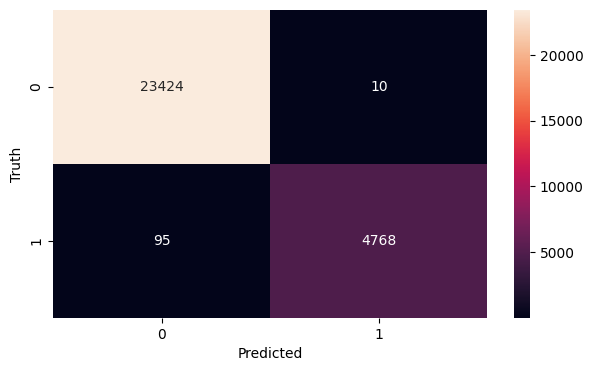

Classification Report and Confusion Matrix for Fold 2:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.97      0.98      4862

    accuracy                           0.99     28296
   macro avg       1.00      0.98      0.99     28296
weighted avg       0.99      0.99      0.99     28296

Ensemble Confusion Matrix:
[[23425     9]
 [  153  4709]]


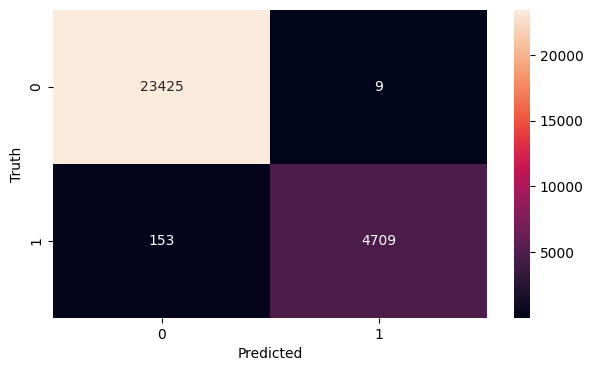

Classification Report and Confusion Matrix for Fold 3:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.97      0.98      4862

    accuracy                           0.99     28296
   macro avg       1.00      0.98      0.99     28296
weighted avg       0.99      0.99      0.99     28296

Ensemble Confusion Matrix:
[[23429     5]
 [  158  4704]]


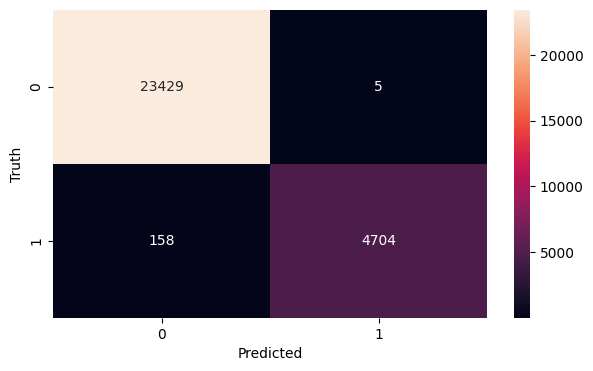

Classification Report and Confusion Matrix for Fold 4:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23434
           1       1.00      0.98      0.99      4862

    accuracy                           1.00     28296
   macro avg       1.00      0.99      0.99     28296
weighted avg       1.00      1.00      1.00     28296

Ensemble Confusion Matrix:
[[23422    12]
 [   98  4764]]


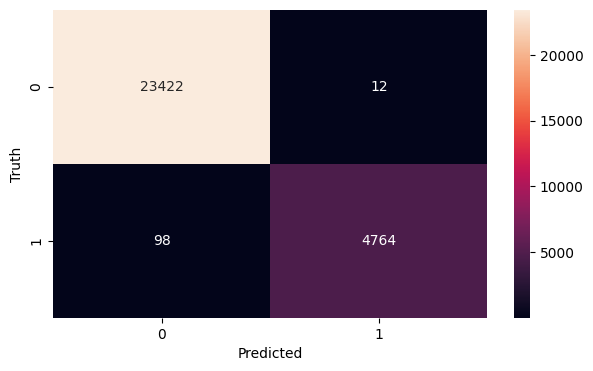

Classification Report and Confusion Matrix for Fold 5:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.96      0.98      4862

    accuracy                           0.99     28296
   macro avg       1.00      0.98      0.99     28296
weighted avg       0.99      0.99      0.99     28296

Ensemble Confusion Matrix:
[[23423    11]
 [  179  4683]]


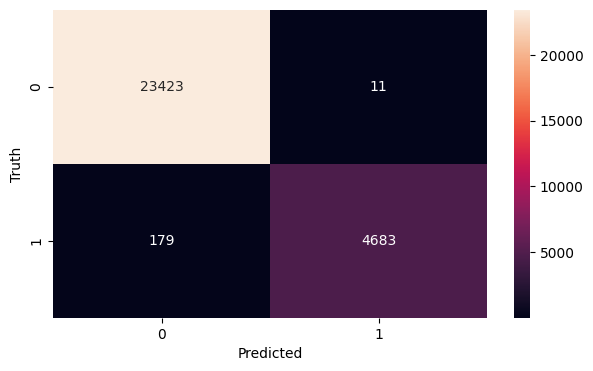

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


# Creating an instance of StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creating a StandardScaler instance
scaler = StandardScaler()

# Creating an ExtraTreesClassifier for feature selection
feature_selector = ExtraTreesClassifier(n_estimators=50)

# Hyperparameter tuning for ANN using RandomizedSearchCV
ann_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

ann_classifier = MLPClassifier(max_iter=10, random_state=42)
ann_random_search = RandomizedSearchCV(ann_classifier, param_distributions=ann_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Creating an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)  # Adjusted for binary classification

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_inf_dropped, y_binary_converted), 1):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_inf_dropped.iloc[train_index], X_inf_dropped.iloc[test_index]
    y_train, y_test = y_binary_converted.iloc[train_index], y_binary_converted.iloc[test_index]

    # Applying SMOTE to the training set for data imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardizing the features
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection
    feature_selector.fit(X_train_scaled, y_train_resampled)
    model = SelectFromModel(feature_selector, prefit=True)
    X_train_selected = model.transform(X_train_scaled)
    X_test_selected = model.transform(X_test_scaled)

    # Hyperparameter tuning for ANN
    ann_random_search.fit(X_train_selected, y_train_resampled)
    best_ann_model = ann_random_search.best_estimator_

    # Train XGBoost classifier
    xgb_classifier.fit(X_train_selected, y_train_resampled)

    # Predictions using both models
    ann_predictions = best_ann_model.predict(X_test_selected)
    xgb_predictions = xgb_classifier.predict(X_test_selected)

    # Combine predictions using majority voting
    ensemble_predictions = [max(set(pred), key=list(pred).count) for pred in zip(ann_predictions, xgb_predictions)]

     # Classification report and confusion matrix
    print(f"Classification Report and Confusion Matrix for Fold {fold}:\n")

    print("Ensemble Classification Report:")
    print(classification_report(y_test, ensemble_predictions))

    print("Ensemble Confusion Matrix:")
    cm = confusion_matrix(y_test, ensemble_predictions)
    print(cm)

    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [ ]:
# @title Ensemble model of Neural network and Random Forest for Scenario1


Classification Report and Confusion Matrix for Fold 1:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.97      0.99      4863

    accuracy                           1.00     28297
   macro avg       1.00      0.99      0.99     28297
weighted avg       1.00      1.00      1.00     28297

Ensemble Confusion Matrix:


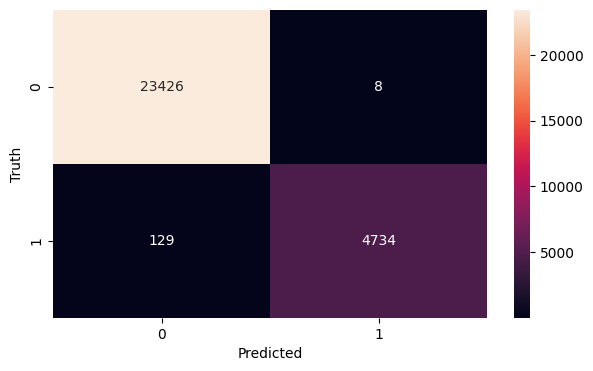

Classification Report and Confusion Matrix for Fold 2:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.97      0.98      4862

    accuracy                           0.99     28296
   macro avg       1.00      0.98      0.99     28296
weighted avg       0.99      0.99      0.99     28296

Ensemble Confusion Matrix:


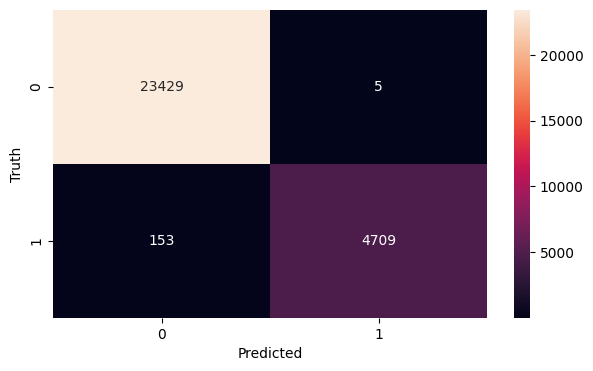

Classification Report and Confusion Matrix for Fold 3:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.98      0.99      4862

    accuracy                           1.00     28296
   macro avg       1.00      0.99      0.99     28296
weighted avg       1.00      1.00      1.00     28296

Ensemble Confusion Matrix:


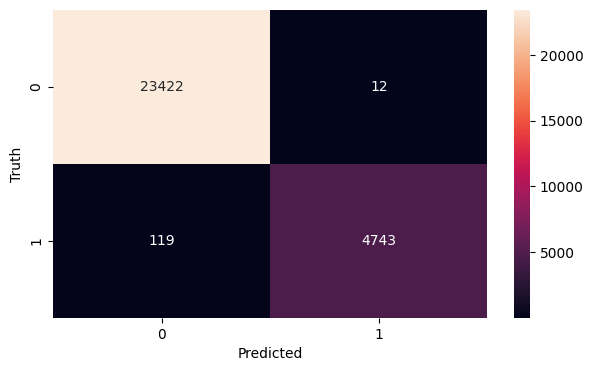

Classification Report and Confusion Matrix for Fold 4:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23434
           1       1.00      0.99      0.99      4862

    accuracy                           1.00     28296
   macro avg       1.00      0.99      0.99     28296
weighted avg       1.00      1.00      1.00     28296

Ensemble Confusion Matrix:


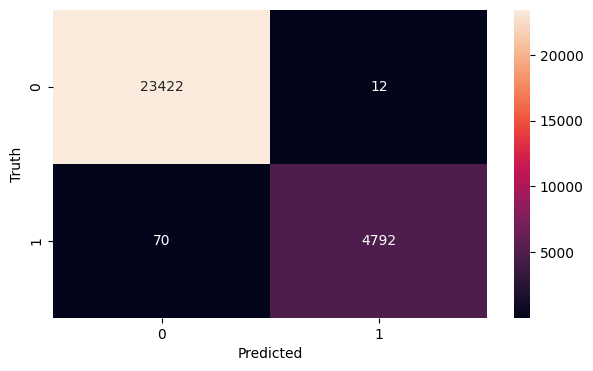

Classification Report and Confusion Matrix for Fold 5:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23434
           1       1.00      0.97      0.99      4862

    accuracy                           1.00     28296
   macro avg       1.00      0.99      0.99     28296
weighted avg       1.00      1.00      1.00     28296

Ensemble Confusion Matrix:


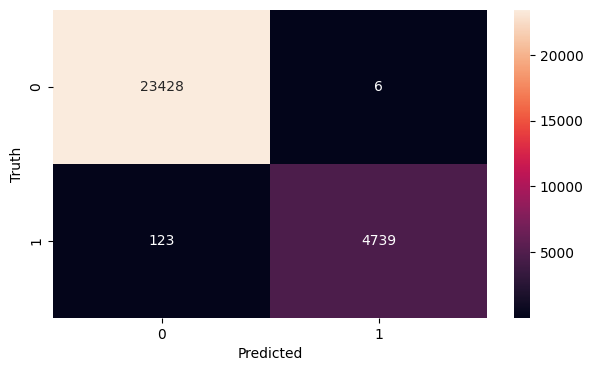

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Creating an instance of StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creating a StandardScaler instance
scaler = StandardScaler()

# Creating an ExtraTreesClassifier for feature selection
feature_selector = ExtraTreesClassifier(n_estimators=50)

# Hyperparameter tuning for ANN using RandomizedSearchCV
ann_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

ann_classifier = MLPClassifier(max_iter=10, random_state=42)
ann_random_search = RandomizedSearchCV(ann_classifier, param_distributions=ann_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Creating a RandomForestClassifier for binary classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_inf_dropped, y_binary_converted), 1):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_inf_dropped.iloc[train_index], X_inf_dropped.iloc[test_index]
    y_train, y_test = y_binary_converted.iloc[train_index], y_binary_converted.iloc[test_index]

    # Applying SMOTE to the training set for data imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardizing the features
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection
    feature_selector.fit(X_train_scaled, y_train_resampled)
    model = SelectFromModel(feature_selector, prefit=True)
    X_train_selected = model.transform(X_train_scaled)
    X_test_selected = model.transform(X_test_scaled)

    # Hyperparameter tuning for ANN
    ann_random_search.fit(X_train_selected, y_train_resampled)
    best_ann_model = ann_random_search.best_estimator_

    # Train RandomForest classifier
    rf_classifier.fit(X_train_selected, y_train_resampled)

    # Predictions using both models
    ann_predictions = best_ann_model.predict(X_test_selected)
    rf_predictions = rf_classifier.predict(X_test_selected)

    # Combine predictions using majority voting
    ensemble_predictions = [max(set(pred), key=list(pred).count) for pred in zip(ann_predictions, rf_predictions)]

    # Classification report and confusion matrix
    print(f"Classification Report and Confusion Matrix for Fold {fold}:\n")

    print("Ensemble Classification Report:")
    print(classification_report(y_test, ensemble_predictions))

    print("Ensemble Confusion Matrix:")
    cm = confusion_matrix(y_test, ensemble_predictions)
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [ ]:
# @title Encoding and pre-processing target variable for Scenario2


In [ ]:
def converting_multi(y):
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_numeric_multi = label_encoder.fit_transform(y)
    y_numeric_multi = pd.Series(y_numeric_multi)

    # Converting unique values to lowercase
    unique_values_lower = np.unique(y.astype(str).str.lower())

    # Mapping the unique lowercase values to the encoded labels
    label_mapping = {val: idx for idx, val in enumerate(unique_values_lower)}
    y_numeric_multi_mapped = y.astype(str).str.lower().map(label_mapping)

    return y_numeric_multi_mapped, unique_values_lower

y_multi_converted_mapped, unique_values_lower = converting_multi(y_multi_inf_dropped)

print(type(y_multi_converted_mapped))
print(y_multi_converted_mapped.shape)

# Print unique values of the target variable
print(f'Unique values of the target variable (lowercase): {unique_values_lower}')

<class 'pandas.core.series.Series'>
(141481,)
Unique values of the target variable (lowercase): ['audio-streaming' 'browsing' 'chat' 'email' 'file-transfer' 'p2p'
 'video-streaming' 'voip']


In [ ]:
# @title Ensemble model of Neural network and XGBoost for Scenario2


Classification Report and Confusion Matrix for Fold 1:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3610
           1       0.88      0.96      0.92      6562
           2       0.79      0.78      0.78      2295
           3       0.72      0.67      0.69      1228
           4       0.80      0.75      0.78      2235
           5       0.99      0.99      0.99      9704
           6       0.73      0.63      0.68      1949
           7       0.77      0.87      0.82       714

    accuracy                           0.89     28297
   macro avg       0.82      0.82      0.82     28297
weighted avg       0.89      0.89      0.89     28297

Ensemble Confusion Matrix:
Classification Report and Confusion Matrix for Fold 2:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3610
           1       0.87      0.97    

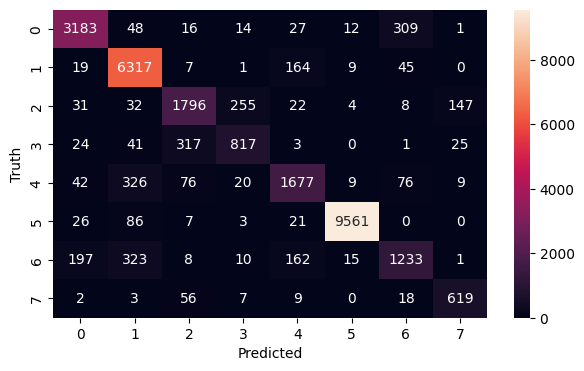

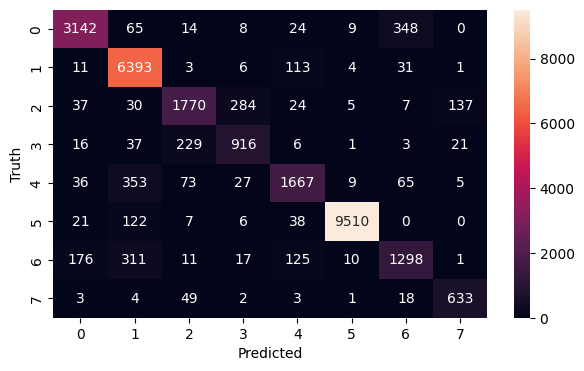

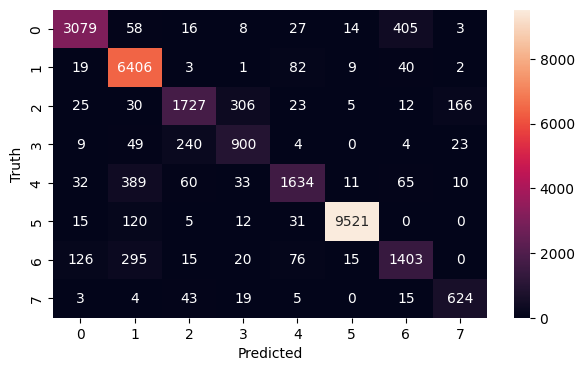

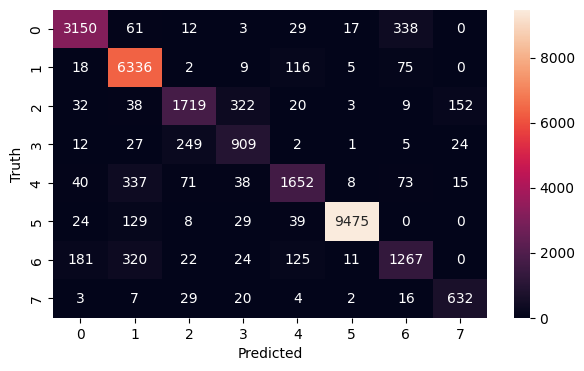

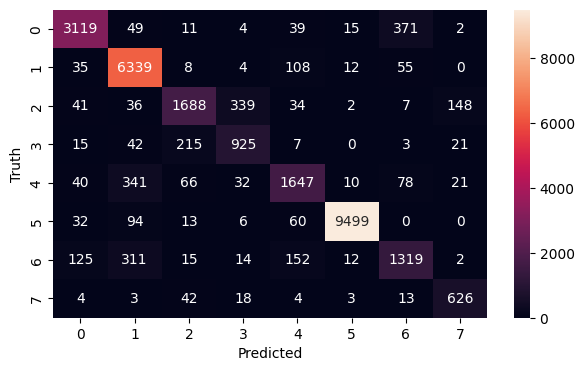

In [ ]:
import tensorflow as tf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


# Creating an instance of StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creating a StandardScaler instance
scaler = StandardScaler()

# Creating an ExtraTreesClassifier for feature selection
feature_selector = ExtraTreesClassifier(n_estimators=50)

# Hyperparameter tuning for ANN using RandomizedSearchCV
ann_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

ann_classifier = MLPClassifier(max_iter=10, random_state=42)
ann_random_search = RandomizedSearchCV(ann_classifier, param_distributions=ann_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Creating an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_multi_converted_mapped)))

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_inf_dropped, y_multi_converted_mapped), 1):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_inf_dropped.iloc[train_index], X_inf_dropped.iloc[test_index]
    y_train, y_test = y_multi_converted_mapped.iloc[train_index], y_multi_converted_mapped.iloc[test_index]

    # Applying SMOTE to the training set for data imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardizing the features
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection
    feature_selector.fit(X_train_scaled, y_train_resampled)
    model = SelectFromModel(feature_selector, prefit=True)
    X_train_selected = model.transform(X_train_scaled)
    X_test_selected = model.transform(X_test_scaled)

    # Hyperparameter tuning for ANN
    ann_random_search.fit(X_train_selected, y_train_resampled)
    best_ann_model = ann_random_search.best_estimator_

    # Train XGBoost classifier
    xgb_classifier.fit(X_train_selected, y_train_resampled)

    # Predictions using both models
    ann_predictions = best_ann_model.predict(X_test_selected)
    xgb_predictions = xgb_classifier.predict(X_test_selected)

    # Combine predictions using majority voting
    ensemble_predictions = [max(set(pred), key=list(pred).count) for pred in zip(ann_predictions, xgb_predictions)]

     # Classification report and confusion matrix
    print(f"Classification Report and Confusion Matrix for Fold {fold}:\n")

    print("Ensemble Classification Report:")
    print(classification_report(y_test, ensemble_predictions))

    print("Ensemble Confusion Matrix:")
    cm = tf.math.confusion_matrix(labels=y_test ,predictions=ensemble_predictions)
    plt.figure(figsize = (7,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

In [ ]:
# @title Ensemble model of Neural network and Random forest for Scenario2


Classification Report and Confusion Matrix for Fold 1:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3610
           1       0.88      0.97      0.92      6562
           2       0.80      0.78      0.79      2295
           3       0.72      0.72      0.72      1228
           4       0.79      0.76      0.78      2235
           5       1.00      0.97      0.98      9704
           6       0.72      0.62      0.66      1949
           7       0.77      0.84      0.81       714

    accuracy                           0.89     28297
   macro avg       0.82      0.82      0.82     28297
weighted avg       0.89      0.89      0.89     28297

Ensemble Confusion Matrix:
Classification Report and Confusion Matrix for Fold 2:

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3610
           1       0.89      0.97    

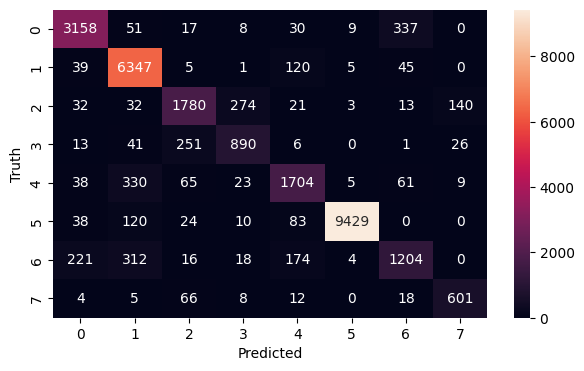

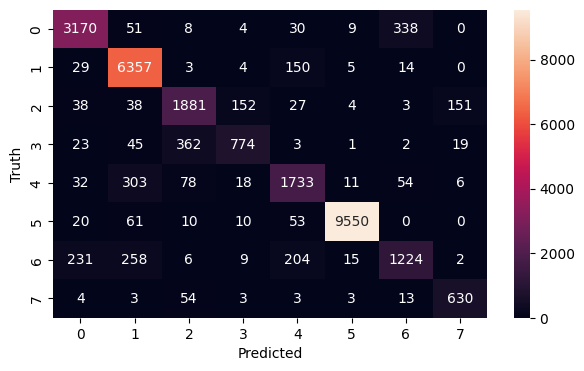

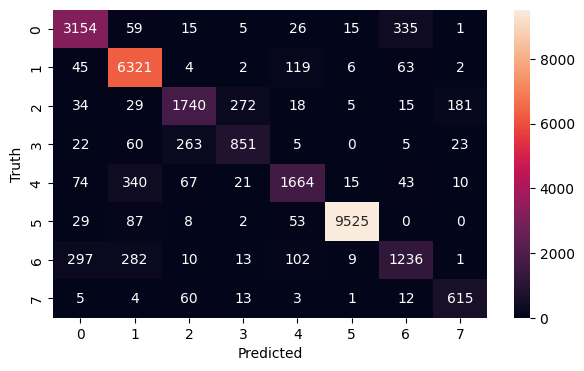

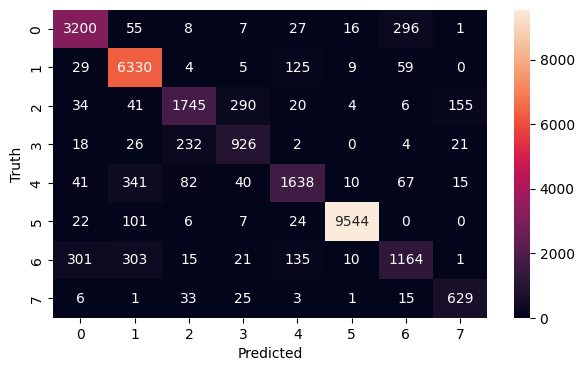

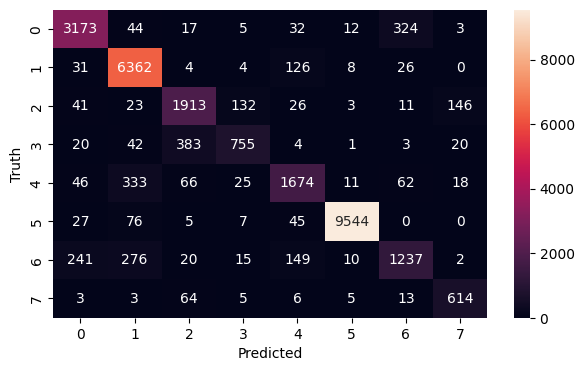

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Creating an instance of StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Creating a StandardScaler instance
scaler = StandardScaler()

# Creating an ExtraTreesClassifier for feature selection
feature_selector = ExtraTreesClassifier(n_estimators=50)

# Hyperparameter tuning for ANN using RandomizedSearchCV
ann_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

ann_classifier = MLPClassifier(max_iter=10, random_state=42)
ann_random_search = RandomizedSearchCV(ann_classifier, param_distributions=ann_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Creating a RandomForestClassifier for classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_inf_dropped, y_multi_converted_mapped), 1):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_inf_dropped.iloc[train_index], X_inf_dropped.iloc[test_index]
    y_train, y_test = y_multi_converted_mapped.iloc[train_index], y_multi_converted_mapped.iloc[test_index]

    # Applying SMOTE to the training set for data imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Standardizing the features
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection
    feature_selector.fit(X_train_scaled, y_train_resampled)
    model = SelectFromModel(feature_selector, prefit=True)
    X_train_selected = model.transform(X_train_scaled)
    X_test_selected = model.transform(X_test_scaled)

    # Hyperparameter tuning for ANN
    ann_random_search.fit(X_train_selected, y_train_resampled)
    best_ann_model = ann_random_search.best_estimator_

    # Train RandomForest classifier
    rf_classifier.fit(X_train_selected, y_train_resampled)

    # Predictions using both models
    ann_predictions = best_ann_model.predict(X_test_selected)
    rf_predictions = rf_classifier.predict(X_test_selected)

     # Combine predictions using majority voting
    ensemble_predictions = [max(set(pred), key=list(pred).count) for pred in zip(ann_predictions, rf_predictions)]

     # Classification report and confusion matrix
    print(f"Classification Report and Confusion Matrix for Fold {fold}:\n")

    print("Ensemble Classification Report:")
    print(classification_report(y_test, ensemble_predictions))

    print("Ensemble Confusion Matrix:")
    cm = tf.math.confusion_matrix(labels=y_test ,predictions=ensemble_predictions)
    plt.figure(figsize = (7,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')